# Лабораторная работа 4.1

## TensorFlow

Выполнил: Пчелкина Ю.Ж., группа 6231-010402D

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [1]:
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm


In [3]:
# количество точек в облаке
N = 300

In [4]:
# тензор Nx2 с нормальными СВ
noise = tf.random.normal((N, 2), 0, 1)

cloud1 = noise + np.array([3, 3])
cloud2 = noise + np.array([-3, 3])
cloud3 = noise + np.array([0, -3])

data = np.vstack([cloud1, cloud2, cloud3])

annotation1 = [0]*N
annotation2 = [1]*N
annotation3 = [2]*N

annotations = annotation1 + annotation2 + annotation3

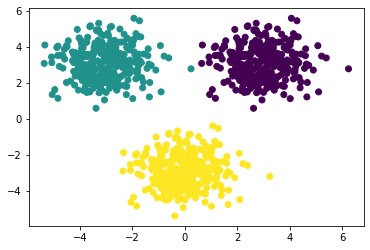

In [5]:
plt.scatter(data[:,0], data[:,1], c=annotations)

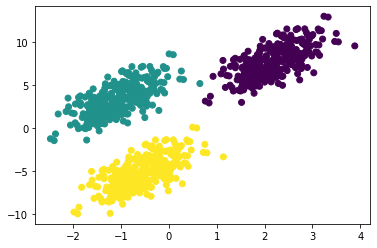

In [29]:
# случайная матрица 2х2 в диапазоне от 0 до 2

matr = tf.random.uniform((2, 2), 0, 2)

cloud11 = tf.matmul(cloud1, matr)
cloud21 = tf.matmul(cloud2, matr)
cloud31 = tf.matmul(cloud3, matr)

data1 = np.vstack([cloud11, cloud21, cloud31])

plt.scatter(data1[:,0], data1[:,1], c=annotations)

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [7]:
mnist = tf.keras.datasets.fashion_mnist.load_data()

In [8]:
# x - изображение, y - метки классов
(x_train, y_train), (x_test, y_test) = mnist

In [9]:
print ('Training data shape: ', x_train.shape)
print ('Training labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)

Training data shape:  (60000, 28, 28)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28)
Test labels shape:  (10000,)


In [10]:
# словарь с названиями классов
dict_classes = {0:'top', 1:'trouser', 2:'pullover', 3:'dress', 4:'coat', 5:'sandal', 6:'shirt', 7:'sneaker', 8:'bag', 9:'boot'}

In [11]:
# функция вывода первых N элементов
def plot_first_images(img, labels, idx, num):
    pred = []
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    for i in range(0, num):
        ax = plt.subplot(5, 10, 1 + i)
        ax.imshow(img[idx], cmap = 'binary')
        title = dict_classes[labels[i]]
        ax.set_title(title, fontsize = 10)
        ax.set_xticks([]); ax.set_yticks([])
        idx += 1
    plt.show()


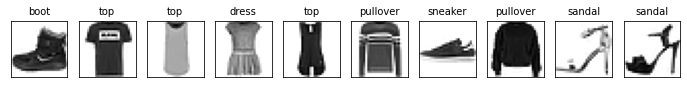

In [12]:
N = 10
plot_first_images (x_train, y_train, 0, N) 

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [13]:
x_train = x_train.reshape(60000, -1)
x_test = x_test.reshape(10000, -1)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [14]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

# Нормализуем данные
mean, std = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - mean) / (std + 1e-3)
x_test = (x_test - mean) / (std + 1e-3)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [15]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

train_dataset = train_dataset.shuffle(buffer_size=len(x_train), reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(128)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)


4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [16]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, name='linear')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), name='bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [17]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        linear_name = None
        if name is not None:
            linear_name = name + '_linear'
        self.linear = Linear(in_d, out_d, name=linear_name)
        
    def __call__(self, x):
        x = self.linear(x)
        return tf.nn.softmax(x)

In [18]:
model = LogisticRegression(28*28,10)
preds = model(x_train[0:1])

In [19]:
tf.argmax(preds, axis=1)

<tf.Tensor: shape=(1,), dtype=int64, numpy=array([9], dtype=int64)>

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [20]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)
    
def evaluate(model, ds):
    y_preds = []
    y_test = []
    for x,y in tqdm(ds):
        preds = model(x)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_test.append(y)
    
    y_test = tf.concat(y_test, axis=0)
    y_preds = tf.concat(y_preds, axis=0)
    y_preds = tf.cast(y_preds, 'int32')
    
    return accuracy(y_test, y_preds).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [21]:
def train_step(model, data, optim, criterion):
    with tf.GradientTape() as tape:
        x, y = data
        preds = model(x)
        loss = criterion(y, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grads, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [22]:
acc = evaluate(model, test_dataset)
print('Acuracy', round(acc * 100, 2), '%')

100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 533.77it/s]

Acuracy 4.92 %


10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [23]:
epochs = 5
print_period = 100

optim = tf.optimizers.Adam(learning_rate=0.005)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy()

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [24]:
loss_data = []
acc_data = []
for epoch in range(epochs):
    cnt = 0
    for x,y in tqdm(train_dataset):

        loss = train_step(model, (x,y), optim, cross_entropy)
        
        if cnt % print_period == 0:
            print('Epoch:', epoch, 'Iteration:', cnt, 'Loss:', loss.numpy())
        loss_data.append(loss.numpy())
        cnt += 1
        
    acc = evaluate(model, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

  5%|█▉                                       | 22/469 [00:00<00:05, 75.24it/s]

Epoch: 0 Iteration: 0 Loss: 2.4308734


 27%|██████████▍                            | 126/469 [00:00<00:02, 163.25it/s]

Epoch: 0 Iteration: 100 Loss: 0.5705075


 50%|███████████████████▍                   | 233/469 [00:01<00:01, 165.86it/s]

Epoch: 0 Iteration: 200 Loss: 0.42611194


 64%|█████████████████████████              | 302/469 [00:02<00:00, 168.44it/s]

Epoch: 0 Iteration: 300 Loss: 0.63214886


 90%|███████████████████████████████████    | 422/469 [00:02<00:00, 160.20it/s]

Epoch: 0 Iteration: 400 Loss: 0.6857066


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 326.43it/s]


Epoch: 0 Accuracy: 0.8137


  3%|█▎                                       | 15/469 [00:00<00:10, 42.69it/s]

Epoch: 1 Iteration: 0 Loss: 0.40503615


 25%|█████████▉                              | 116/469 [00:01<00:04, 85.50it/s]

Epoch: 1 Iteration: 100 Loss: 0.41519627


 46%|█████████████████▉                     | 215/469 [00:02<00:02, 111.57it/s]

Epoch: 1 Iteration: 200 Loss: 0.48248997


 67%|██████████████████████████▏            | 315/469 [00:03<00:01, 135.92it/s]

Epoch: 1 Iteration: 300 Loss: 0.43369198


 90%|███████████████████████████████████    | 421/469 [00:03<00:00, 136.59it/s]

Epoch: 1 Iteration: 400 Loss: 0.4102096


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 711.67it/s]


Epoch: 1 Accuracy: 0.8295


  4%|█▋                                       | 19/469 [00:00<00:07, 63.91it/s]

Epoch: 2 Iteration: 0 Loss: 0.40344933


 27%|██████████▍                            | 126/469 [00:01<00:02, 161.38it/s]

Epoch: 2 Iteration: 100 Loss: 0.34192553


 46%|██████████████████▏                    | 218/469 [00:01<00:01, 165.70it/s]

Epoch: 2 Iteration: 200 Loss: 0.2636732


 70%|███████████████████████████▎           | 329/469 [00:02<00:00, 170.19it/s]

Epoch: 2 Iteration: 300 Loss: 0.39102462


 90%|███████████████████████████████████▏   | 423/469 [00:02<00:00, 170.03it/s]

Epoch: 2 Iteration: 400 Loss: 0.6994747


100%|████████████████████████████████████████| 79/79 [00:00<00:00, 1058.93it/s]


Epoch: 2 Accuracy: 0.8244


  4%|█▌                                       | 18/469 [00:00<00:06, 66.94it/s]

Epoch: 3 Iteration: 0 Loss: 0.3948235


 28%|██████████▊                            | 130/469 [00:00<00:02, 169.10it/s]

Epoch: 3 Iteration: 100 Loss: 0.41512924


 48%|██████████████████▋                    | 224/469 [00:01<00:01, 167.36it/s]

Epoch: 3 Iteration: 200 Loss: 0.4017145


 69%|██████████████████████████▊            | 323/469 [00:02<00:00, 184.39it/s]

Epoch: 3 Iteration: 300 Loss: 0.47208035


 89%|██████████████████████████████████▊    | 418/469 [00:02<00:00, 185.90it/s]

Epoch: 3 Iteration: 400 Loss: 0.3049931


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 678.68it/s]


Epoch: 3 Accuracy: 0.8288


  4%|█▋                                       | 19/469 [00:00<00:06, 70.81it/s]

Epoch: 4 Iteration: 0 Loss: 0.53990555


 29%|███████████▏                           | 134/469 [00:00<00:01, 177.70it/s]

Epoch: 4 Iteration: 100 Loss: 0.48601007


 49%|███████████████████                    | 229/469 [00:01<00:01, 182.50it/s]

Epoch: 4 Iteration: 200 Loss: 0.5131264


 69%|███████████████████████████            | 325/469 [00:02<00:00, 183.84it/s]

Epoch: 4 Iteration: 300 Loss: 0.5604446


 90%|███████████████████████████████████▏   | 423/469 [00:02<00:00, 183.45it/s]

Epoch: 4 Iteration: 400 Loss: 0.35112065


100%|████████████████████████████████████████| 79/79 [00:00<00:00, 1103.30it/s]

Epoch: 4 Accuracy: 0.8303


12 Выведите графики точности и ошибки, используя matplotlib.

In [25]:
v_1 = np.arange(0, len(loss_data), 1)
print(len(v_1))
v_2 = np.arange(0, len(acc_data), 1)
print(len(v_2))

2345
5


13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 

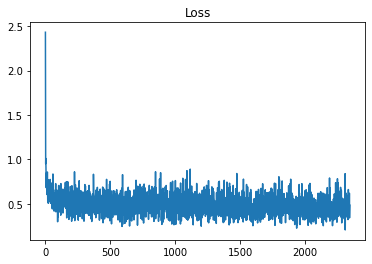

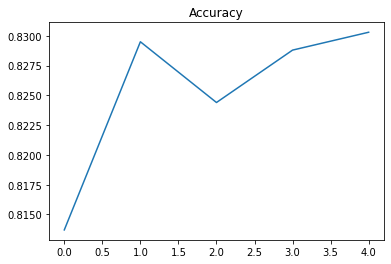

In [26]:
plt.plot(v_1,loss_data)
plt.title("Loss")
plt.show()

plt.plot(v_2,acc_data)
plt.title("Accuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи.

In [27]:
linear_layer = tf.keras.layers.Dense(10)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

for epoch in range(epochs):
    for step, (x, y) in enumerate(train_dataset):

        with tf.GradientTape() as tape:
            logits = linear_layer(x)
            loss = cross_entropy(y, logits)
        gradients = tape.gradient(loss, linear_layer.trainable_weights)
        optimizer.apply_gradients(zip(gradients, linear_layer.trainable_weights))
        if step % 100 == 0:
            print("Step:", step, "Loss:", float(loss))
    acc = evaluate(linear_layer, test_dataset)
    print('Epoch:', epoch, 'Accuracy:', acc)
    acc_data.append(acc)

Step: 0 Loss: 3.1313695907592773
Step: 100 Loss: 1.7851595878601074
Step: 200 Loss: 1.1939148902893066
Step: 300 Loss: 1.1043752431869507
Step: 400 Loss: 1.0389662981033325


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 705.32it/s]


Epoch: 0 Accuracy: 0.6634
Step: 0 Loss: 0.894740104675293
Step: 100 Loss: 0.7826100587844849
Step: 200 Loss: 0.8831436634063721
Step: 300 Loss: 0.9337350726127625
Step: 400 Loss: 0.7912901639938354


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 699.10it/s]


Epoch: 1 Accuracy: 0.7234
Step: 0 Loss: 0.7789547443389893
Step: 100 Loss: 0.7218766212463379
Step: 200 Loss: 0.7237181663513184
Step: 300 Loss: 0.6979186534881592
Step: 400 Loss: 0.6069313287734985


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 603.02it/s]


Epoch: 2 Accuracy: 0.7496
Step: 0 Loss: 0.6725685000419617
Step: 100 Loss: 0.7109386920928955
Step: 200 Loss: 0.6392266750335693
Step: 300 Loss: 0.5704054832458496
Step: 400 Loss: 0.5531651377677917


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 814.39it/s]


Epoch: 3 Accuracy: 0.7687
Step: 0 Loss: 0.7855787873268127
Step: 100 Loss: 0.6961138844490051
Step: 200 Loss: 0.6207399368286133
Step: 300 Loss: 0.7457932829856873
Step: 400 Loss: 0.5662239789962769


100%|█████████████████████████████████████████| 79/79 [00:00<00:00, 916.44it/s]

Epoch: 4 Accuracy: 0.7796
